In [1]:
import importlib
import os
import sys

import numpy as np
import pandas as pd
from datasets import Dataset
sys.path.append("../")

import src

importlib.reload(src)

from src.data_prep_utils import (  # noqa: E402
    conala_to_time_batches,
    load_time_sorted_conala,
)

importlib.reload(src.data_prep_utils)


from src.training import nd_inference, retraining, continual
importlib.reload(src.training)

import torch
from transformers import (
    DataCollatorForSeq2Seq,
    RobertaTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    T5ForConditionalGeneration,
)
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from src.processing_utils import compute_metric_with_params, prepare_hg_ds
from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
import evaluate

/home/RDC/zinovyee.hub/.conda/envs/dd_spek/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /home/RDC/zinovyee.hub/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#%pip install rouge_score
#%pip install absl
#%pip install seaborn
#%pip install transformers[torch]

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
MODEL = "CodeT5"
TRAIN_N = 330
BATCH_SIZE = 15
DECODER_LENGTH = 20
ENCODER_LENGTH = 15

TRAIN_ARGS = {
    "TRAIN_N": TRAIN_N,
    "BATCH_SIZE": BATCH_SIZE,
    "DECODER_LENGTH": DECODER_LENGTH,
    "ENCODER_LENGTH": ENCODER_LENGTH,
    "MODEL": MODEL,
    "SEQ_TRAINER_ARGS": {
        "overwrite_output_dir": True,
        "num_train_epochs": 3,
        "do_train": True,
        "do_eval": True,
        "per_device_train_batch_size": 4,
        "per_device_eval_batch_size": 4,
        "learning_rate": 5e-4,
        "warmup_steps": 100,
        "weight_decay": 0.1,
        "label_smoothing_factor": 0.1,
        "predict_with_generate": True,
        "logging_steps": 100,
        "save_total_limit": 1,
        "save_strategy": "no",
        "logging_strategy": "epoch",
        "evaluation_strategy": "epoch",
        "load_best_model_at_end": False,
    },
}

In [27]:
#df = load_time_sorted_conala("../data/raw/conala")  # noqa: PD901
#df = conala_to_time_batches(df, 30, BATCH_SIZE)  # noqa: PD901
DATE_STR = "20240327"
df = pd.read_csv(f"../data/processed/conala/{DATE_STR}/all_drifts.csv")
df["t_batch"] = df["time_batch"]

model_name="SEBIS/code_trans_t5_base_source_code_summarization_python_multitask"#"Salesforce/codet5-base-multi-sum"
tokenizer = AutoTokenizer.from_pretrained(model_name, skip_special_tokens=False)

tokenizer_config.json: 100%|██████████| 24.0/24.0 [00:00<00:00, 77.1kB/s]
config.json: 100%|██████████| 636/636 [00:00<00:00, 1.97MB/s]
spiece.model: 100%|██████████| 797k/797k [00:00<00:00, 1.99MB/s]
special_tokens_map.json: 100%|██████████| 1.79k/1.79k [00:00<00:00, 4.63MB/s]


ValueError: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.

In [ ]:
df.loc[df.rewritten_intent.isna(), "rewritten_intent"] = "translate an ISO 8601 datetime string into a Python datetime object"

In [ ]:
def prep_for_hf(df: pd.DataFrame, batch_id: int|list, batch_name: str) -> Dataset:
    """Convert pandas dataframe to huggingface."""
    df = df.rename(columns={"snippet": "input_sequence",  # noqa: PD901
                    "rewritten_intent" : "output_sequence"})
    if isinstance(batch_id, list):
        df = df.loc[df[batch_name].isin(batch_id), ["input_sequence", "output_sequence", "idx"]]  # noqa: PD901
    elif isinstance(batch_id, int):
        df = df.loc[df[batch_name]==batch_id, ["input_sequence", "output_sequence", "idx"]]  # noqa: PD901
    df = df.sample(frac=1, random_state=42)  # noqa: PD901
    return Dataset.from_pandas(df)

In [ ]:
def batch_tokenize_preprocess(batch, tokenizer, max_input_length, max_output_length):

    source = batch["input_sequence"]
    target = batch["output_sequence"]

    source_tokenized = tokenizer(
        source, padding="max_length",
        truncation=True, max_length=max_input_length
    )

    target_tokenized = tokenizer(
        target, padding="max_length",
        truncation=True, max_length=max_output_length
    )

    batch = {k: v for k, v in source_tokenized.items()}

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label]
        for label in target_tokenized["input_ids"]
    ]

    return batch

In [ ]:
COLUMN_BATCH = "time_batch"

train_dataset = prep_for_hf(df, list(range(11)), COLUMN_BATCH)

train_data = train_dataset.map(
        lambda batch: batch_tokenize_preprocess(
            batch,
            tokenizer=tokenizer,
            max_input_length=15,
            max_output_length=20,
        ),
        batch_size=4,
        batched=True,
        #remove_columns=train_dataset.column_names,
    )

test_dataset = prep_for_hf(df, list(range(11, df[COLUMN_BATCH].max()+1)), COLUMN_BATCH)

test_data = test_dataset.map(
        lambda batch: batch_tokenize_preprocess(
            batch,
            tokenizer=tokenizer,
            max_input_length=15,
            max_output_length=20,
        ),
        batch_size=4,
        batched=True,
        #remove_columns=train_dataset.column_names,
    )

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

compute_metrics = compute_metric_with_params(tokenizer)

cuda


In [28]:
TRAIN_ARGS["SEQ_TRAINER_ARGS"]["output_dir"] = f'reports/{COLUMN_BATCH}/nd_infer/results'
TRAIN_ARGS["SEQ_TRAINER_ARGS"]["logging_dir"] = f'reports/{COLUMN_BATCH}/nd_infer/logs'

if not os.path.exists(f'reports/{COLUMN_BATCH}'): 
    os.mkdir(f'reports/{COLUMN_BATCH}')

training_args = Seq2SeqTrainingArguments(
        **TRAIN_ARGS["SEQ_TRAINER_ARGS"],
    )


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/RDC/zinovyee.hub/.conda/envs/dd_spek/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [29]:
MODEL_PATH = f"reports/{COLUMN_BATCH}/nd_infer/saved_model"
if not os.path.exists(MODEL_PATH): 
    os.mkdir(MODEL_PATH)

In [30]:
trainer.train()
trainer.save_model(MODEL_PATH)

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len,Bleu,Brevity Penalty,Length Ratio,Translation Length,Reference Length
1,1.904700,4.222258,0.343300,0.115100,0.305400,0.305700,14.709000,0.127000,0.931100,0.933400,25717,27552
2,1.905200,4.222282,0.356800,0.125100,0.314500,0.314900,14.141700,0.126500,0.872000,0.879500,24232,27552
3,1.706100,4.176779,0.369200,0.136100,0.327400,0.328100,14.461600,0.142700,0.881100,0.887700,24457,27552


/home/RDC/zinovyee.hub/.conda/envs/dd_spek/lib/python3.11/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


In [31]:
def generate_summary(test_samples, model, tokenizer, encoder_max_length, decoder_max_length):

    inputs = tokenizer(
        test_samples["input_sequence"],
        padding="max_length",
        truncation=True,
        max_length=encoder_max_length,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=decoder_max_length)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str

In [32]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, skip_special_tokens=False)

In [33]:
text = df.snippet.values
summaries = generate_summary(test_data, model, tokenizer, 15, 20)

df[f"{COLUMN_BATCH}_prediction_nd"] = "USED IN TRAIN"
df.loc[df[COLUMN_BATCH]>=11, f"{COLUMN_BATCH}_prediction_nd"] = summaries[1]

In [35]:
rouge = evaluate.load('rouge')

df[f"{COLUMN_BATCH}_prediction_nd_rouge"] = -999
df[f"{COLUMN_BATCH}_prediction_nd_rouge"] = df[df[COLUMN_BATCH]>=11].progress_apply(lambda x: rouge.compute(predictions=[x[f"{COLUMN_BATCH}_prediction_nd"]], references=[x["rewritten_intent"]])["rouge1"], axis=1)

ind_av_rouge = {}
batch_rouge_calculations = {}
for t_batch in range(1, df[COLUMN_BATCH].max()+1):
    ind_av_rouge[t_batch] = df.loc[df[COLUMN_BATCH]==t_batch, f"{COLUMN_BATCH}_prediction_nd_rouge"].mean()
    batch_rouge_calculations[t_batch] = rouge.compute(predictions=df.loc[df[COLUMN_BATCH]==t_batch, f"{COLUMN_BATCH}_prediction_nd"].values, references=df.loc[df[COLUMN_BATCH]==t_batch, "rewritten_intent"].values)["rouge1"]

ind_av_rouge_nd = np.array(list(ind_av_rouge.values()))
batch_rouge_calculations_nd = np.array(list(batch_rouge_calculations.values()))

  0%|          | 2/2110 [00:00<03:08, 11.19it/s]INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
100%|██████████| 2110/2110 [03:59<00:00,  8.80it/s]
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default t

In [39]:
ind_av_rouge_nd

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.08468892, 0.14461523, 0.11871417, 0.1152382 , 0.09815855,
       0.08461947, 0.10096207, 0.11834496, 0.10993622, 0.10096041,
       0.13546362, 0.11328898, 0.11417762, 0.12578386, 0.11969696,
       0.09680829, 0.08993692, 0.10567827, 0.10151432, 0.10374683,
       0.10052032, 0.10985549, 0.08809511, 0.13533317, 0.11105268,
       0.10513645, 0.10507946, 0.12342668, 0.14168249, 0.07518246,
       0.09036965, 0.08420386, 0.11437159, 0.11221719, 0.08984822,
       0.08632135, 0.08516742, 0.13199073, 0.08682723, 0.097085  ,
       0.15028732, 0.08176426, 0.14090575, 0.11573124, 0.09971399,
       0.10909455, 0.13304386, 0.0992136 , 0.11469471, 0.12204592,
       0.1303381 , 0.09472975, 0.09238847, 0.12614138, 0.08798246])

In [46]:
batch_rouge_calculations_nd

array([0.03149118, 0.04651758, 0.07287669, 0.04716621, 0.0519755 ,
       0.02584267, 0.06639654, 0.05126813, 0.0491036 , 0.04776335,
       0.0847129 , 0.14509066, 0.11961772, 0.11433795, 0.09788549,
       0.08458418, 0.10039315, 0.11850517, 0.11070642, 0.10062374,
       0.13542408, 0.11307251, 0.11466024, 0.1260714 , 0.11949531,
       0.0969807 , 0.09052475, 0.10523089, 0.10072654, 0.10306277,
       0.09894412, 0.10884068, 0.08842339, 0.1369818 , 0.11039604,
       0.10530818, 0.10424138, 0.12336962, 0.14119042, 0.07414483,
       0.0906845 , 0.08370405, 0.11296782, 0.11281154, 0.0898515 ,
       0.08680035, 0.08328066, 0.13322486, 0.0864336 , 0.09677599,
       0.14937711, 0.08139542, 0.14037723, 0.11407942, 0.09932757,
       0.10916047, 0.13302146, 0.09896987, 0.11447197, 0.12235826,
       0.13064426, 0.09512377, 0.09207974, 0.12583148, 0.08798246])

In [49]:
len(range(11,66))

55

In [51]:
df

,question_id,intent,rewritten_intent,snippet,idx,time_batch,cluster,gradual_batch,gradual_new,recurring_batch,rec_new,sudden_batch,sudden_new,t_batch,time_batch_prediction_nd,time_batch_prediction_nd_rouge
0,1476,express binary literals,convert binary string '11111111' to integer,"int('11111111', 2)",0,0,5,53,0,53,0,53,0,0,USED IN TRAIN,NaN
1,1476,express binary literals,convert 21 to binary string,bin(21),1,0,5,55,0,55,0,55,0,0,USED IN TRAIN,NaN
2,1476,express binary literals,convert binary string '0b0010101010' to integer,"int('0b0010101010', 2)",2,0,5,49,0,49,0,49,0,0,USED IN TRAIN,NaN
3,1476,express binary literals,convert binary string '010101' to integer,"int('010101', 2)",3,0,5,50,0,50,0,50,0,0,USED IN TRAIN,NaN
4,1476,express binary literals,convert binary string '01010101111' to integer,"int('01010101111', 2)",4,0,5,51,0,51,0,51,0,0,USED IN TRAIN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,42462530,How to replace the white space in a string in ...,replace white spaces in dataframe `df` with '_',"df.replace(' ', '_', regex=True)",2874,64,3,63,0,58,0,44,0,64,download a file `url` over HTTP,0.000000
2875,42548362,Python. Convert escaped utf string to utf-string,Convert escaped utf string to utf string in `y...,print('your string'.decode('string_escape')),2875,65,8,0,0,62,0,40,0,65,"compare two lists in python `[1, 2, 3]` and `[",0.105263
2876,42731970,Regex add character to matched string,replace periods `.` that are not followed by p...,"re.sub('\\.(?=[^ .])', '. ', para)",2876,65,8,1,0,63,0,43,0,65,remove parentheses and text within it in strin...,0.080000
2877,42747987,In pandas Dataframe with multiindex how can I ...,select the first row grouped per level 0 of da...,"df.groupby(level=0, as_index=False).nth(0)",2877,65,3,12,0,23,0,63,0,65,limit float 135578.46 to two decimal points,0.000000


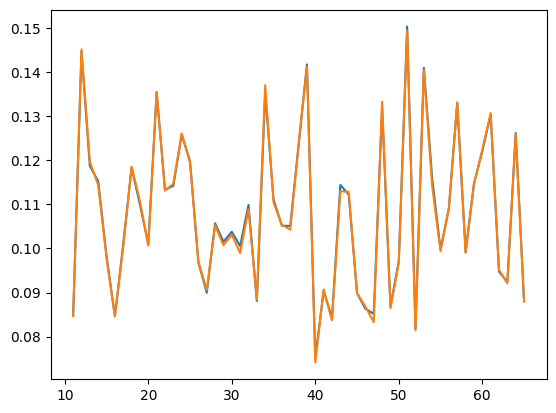

In [50]:
import matplotlib.pyplot as plt
sns.lineplot(x=range(11,66), y=ind_av_rouge_nd[10:])
sns.lineplot(x=range(11, 66), y=batch_rouge_calculations_nd[10:])
plt.savefig(f'reports/{COLUMN_BATCH}/nd_infer/output.png')

In [ ]:
# SAVE RESULTS
import pickle
df.to_csv(f'reports/{COLUMN_BATCH}/nd_infer/results.csv')

with open(f'reports/{COLUMN_BATCH}/nd_infer/ind_av_rouge_nd.pickle', 'wb') as handle:
    pickle.dump(ind_av_rouge_nd, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'reports/{COLUMN_BATCH}/nd_infer/batch_rouge_calculations_nd.pickle', 'wb') as handle:
    pickle.dump(batch_rouge_calculations_nd, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
df

,question_id,intent,rewritten_intent,snippet,idx,time_batch,cluster,gradual_batch,gradual_new,recurring_batch,rec_new,sudden_batch,sudden_new,t_batch,time_batch_prediction_nd,time_batch_prediction_nd_rouge
0,1476,express binary literals,convert binary string '11111111' to integer,"int('11111111', 2)",0,0,5,53,0,53,0,53,0,0,USED IN TRAIN,NaN
1,1476,express binary literals,convert 21 to binary string,bin(21),1,0,5,55,0,55,0,55,0,0,USED IN TRAIN,NaN
2,1476,express binary literals,convert binary string '0b0010101010' to integer,"int('0b0010101010', 2)",2,0,5,49,0,49,0,49,0,0,USED IN TRAIN,NaN
3,1476,express binary literals,convert binary string '010101' to integer,"int('010101', 2)",3,0,5,50,0,50,0,50,0,0,USED IN TRAIN,NaN
4,1476,express binary literals,convert binary string '01010101111' to integer,"int('01010101111', 2)",4,0,5,51,0,51,0,51,0,0,USED IN TRAIN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,42462530,How to replace the white space in a string in ...,replace white spaces in dataframe `df` with '_',"df.replace(' ', '_', regex=True)",2874,64,3,63,0,58,0,44,0,64,download a file `url` over HTTP and save to `f...,0.000000
2875,42548362,Python. Convert escaped utf string to utf-string,Convert escaped utf string to utf string in `y...,print('your string'.decode('string_escape')),2875,65,8,0,0,62,0,40,0,65,check if numpy array `a` is equal to two integers,0.100000
2876,42731970,Regex add character to matched string,replace periods `.` that are not followed by p...,"re.sub('\\.(?=[^ .])', '. ', para)",2876,65,8,1,0,63,0,43,0,65,"remove a substring "".1"" from the end of string...",0.076923
2877,42747987,In pandas Dataframe with multiindex how can I ...,select the first row grouped per level 0 of da...,"df.groupby(level=0, as_index=False).nth(0)",2877,65,3,12,0,23,0,63,0,65,limit float 135578.46 to two decimal points,0.000000
